In [150]:
import pandas as pd
import numpy as np

df = pd.read_csv("assignment_3_dataset.csv")





    Subject ID (person),
    Programming language (lang),
    Run time for z1000 input file in minutes (z1000t),
    Run time for z0 input file in minutes (z0t),
    Memory consumption at the end of run for z1000 input file in kilobytes (z1000mem),
    Program length in statement lines of code (stmtL),
    Output reliability for z1000 input file in percent (z1000rel),
    Output reliability for m1000 input file in percent (m1000rel),
    Total subject work time in hours (whours),
    Subject’s answer to the capability question “I consider myself to be among the top X percent of all programmers” (caps).


In [151]:
df.head()

,Unnamed: 0,person,lang,z1000t,z0t,z1000mem,stmtL,z1000rel,m1000rel,whours,caps
0,3,s066,C,0.750,0.467,2952,7.3,98.48,100.0,7.3,??
1,13,s051,C++,0.150,0.033,3448,15.2,100.00,98.4,15.2,??
2,9,s027,c++,1.533,0.000,3472,25.3,98.09,100.0,25.3,??
3,14,s090,C++,1.667,0.033,4152,19.6,98.48,100.0,19.6,??
4,15,s096,C++,0.917,0.017,5240,6.9,100.00,100.0,6.9,??


## Cleaning and normalization 
---
1. The 'caps' column has "??" and emtpy values which are normalized to not answered
2. Fixing 'lang' spelling inconsistencies with capital and non capital spellings.
3. Fixing empty cells in "z1000t" where empty cells should be 0, Converting all values to floats & rounding to 3 decimals.
4. Fixing empty cells in "stmlL" empty cells to *not answered*, and rounding all values upwards and into ints. Since you can't have 0 lines of code or 0.4 lines of code.
5. For both "z1000rel" and "m1000rel" normalized to make all value float with 2 decimals.
6. For "whours" for each missing cell set a 0, also use consistancy and use floats with 1 decimal for all values.

In [152]:
for c in df.columns:
    df[c] = df[c].replace(('','??'), np.nan).fillna("not answered")

In [153]:
df

,Unnamed: 0,person,lang,z1000t,z0t,z1000mem,stmtL,z1000rel,m1000rel,whours,caps
0,3,s066,C,0.75,0.467,2952,7.3,98.48,100.0,7.3,not answered
1,13,s051,C++,0.15,0.033,3448,15.2,100.00,98.4,15.2,not answered
2,9,s027,c++,1.533,0.000,3472,25.3,98.09,100.0,25.3,not answered
3,14,s090,C++,1.667,0.033,4152,19.6,98.48,100.0,19.6,not answered
4,15,s096,C++,0.917,0.017,5240,6.9,100.00,100.0,6.9,not answered
...,...,...,...,...,...,...,...,...,...,...,...
75,41,s149102,Perl,21.4,0.417,73440,1.67,0.00,0.0,1.67,10-25%
76,46,s149108,Perl,0.483,0.433,73448,2.83,100.00,100.0,2.83,10-25%
77,34,s081,Java,0.2,0.150,79544,26.6,100.00,10.2,26.6,not answered
78,17,s023,Java,2.633,0.650,89664,7.1,7.60,98.4,7.1,not answered


In [154]:
# 2.Lang has spelling inconsistencies with captial and non capital letters

df['lang'] = df['lang'].str.capitalize()
df['lang'].value_counts(dropna=False)


lang
Java      24
Python    13
Perl      13
C++       11
Tcl       10
C          5
Rexx       4
Name: count, dtype: int64

In [155]:
#convert all ints to floats to make it easier to handle
for c in df.columns:
    df[c] = df[c].apply(lambda x: float(x) if isinstance(x, int) else x)

In [156]:
## Remove the outliers as they are deemed as mistake values

#For each with excessive whours they have the same amount in stmL
df['stmtL'] = pd.to_numeric(df['stmtL'], errors='coerce')
df['whours'] = pd.to_numeric(df['whours'], errors='coerce')
# Pick these and list them

outliers = df[
    (df["stmtL"] == df["whours"]) &
    (df["stmtL"] >= 34632)
]
print("Years coding:", (34632 / 40) / 52)


Years coding: 16.65


**Motivation**
Upon examining the data, several entries contain extremely high values for both stmtL (lines of code) and whours (work hours). For example, participant s149401 reports 34,632 work hours and the same number of lines of code. Assuming a typical full-time workload of approximately 2,000 hours per year (40 hours/week × 52 weeks), this would correspond to more than 16 years of continuous full-time development on the same task. This scenario is incompatible with the experimental context of the dataset, where productivity was measured in a controlled study rather than across decades of professional work.

These observations are therefore considered implausible measurement errors. To prevent distortion of statistical summaries and visualizations, entries exceeding the largest plausible observation (34,632) were excluded for both variables (whours and stmtL) using a single consistent threshold.

In [157]:
df = df.drop(df[df['stmtL'] >= 34632].index)

In [158]:
df

,Unnamed: 0,person,lang,z1000t,z0t,z1000mem,stmtL,z1000rel,m1000rel,whours,caps
0,3.0,s066,C,0.75,0.467,2952.0,7.30,98.48,100.0,7.30,not answered
1,13.0,s051,C++,0.15,0.033,3448.0,15.20,100.00,98.4,15.20,not answered
2,9.0,s027,C++,1.533,0.000,3472.0,25.30,98.09,100.0,25.30,not answered
3,14.0,s090,C++,1.667,0.033,4152.0,19.60,98.48,100.0,19.60,not answered
4,15.0,s096,C++,0.917,0.017,5240.0,6.90,100.00,100.0,6.90,not answered
...,...,...,...,...,...,...,...,...,...,...,...
75,41.0,s149102,Perl,21.4,0.417,73440.0,1.67,0.00,0.0,1.67,10-25%
76,46.0,s149108,Perl,0.483,0.433,73448.0,2.83,100.00,100.0,2.83,10-25%
77,34.0,s081,Java,0.2,0.150,79544.0,26.60,100.00,10.2,26.60,not answered
78,17.0,s023,Java,2.633,0.650,89664.0,7.10,7.60,98.4,7.10,not answered


## Exploratory Data Analysis

---

- Take average lines of code per language and average workhours and compare

In [164]:
df['stmtL_temp'] = pd.to_numeric(df['stmtL'], errors='coerce')

# Group by language and calculate the mean
lang_summary = df.groupby('lang')[['stmtL_temp', 'whours']].mean()

lang_summary



,stmtL_temp,whours
lang,,
C,9.300000,9.300000
C++,11.420000,11.420000
Java,15.572727,15.572727
Perl,3.378462,3.378462
Python,3.205000,3.205000
Rexx,5.482500,5.482500
Tcl,4.716250,4.716250


In [166]:
df.drop(['stmtL_temp'])

KeyError: "['stmtL_temp'] not found in axis"

This shows the tha average lines of code and average workhours spent per language where we also can see that Java and TCL have significantly larger work hours and large code bases. We can also se a correlation between lines of code and work hours.



Exluding the outliers gives a bit more comparable data to the other progamming languages.

In [115]:
df['z1000t_temp'] = pd.to_numeric(df['z1000t'], errors='coerce')
# Group by language and calculate the mean
speed_sum = df.groupby('lang')[['z1000t_temp']].mean()

df = df.drop(df[['stmtL_temp']])

speed_sum

,z1000t_temp
lang,
C,5.429250
C++,2.974182
Java,4.937182
Perl,7.625000
Python,6.434667
Rexx,15.739000
Tcl,26.326000


In [77]:
df[['stmtL', 'whours']].describe()


,stmtL,whours
count,74.000000,74.000000
mean,8.720811,8.720811
std,10.542515,10.542515
min,0.000000,0.000000
25%,3.000000,3.000000
50%,5.250000,5.250000
75%,9.950000,9.950000
max,63.200000,63.200000


In [78]:
# Convert to numeric, invalid entries become NaN
df['z1000mem'] = pd.to_numeric(df['z1000mem'], errors='coerce')

#Mean, median, max memory usage per language
memory_summary = df_mem.groupby('lang')['z1000mem'].agg(['mean', 'median', 'max','min', 'count']).sort_values('mean', ascending=False)
memory_summary

## Correlation Analysis

---

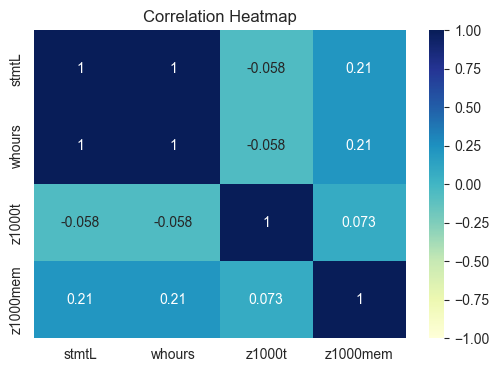

In [79]:



import seaborn as sns
import matplotlib.pyplot as plt


cols = ['stmtL', 'whours', 'z1000t', 'z1000mem']

# Convert all to numeric; non-numeric entries become NaN
numeric_df = df[cols].apply(pd.to_numeric, errors='coerce')

# Compute correlation
corr = numeric_df.corr(method='pearson')

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='YlGnBu', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

| Pearson correlation coefficient (r) value | Strength  | Direction |
|--------------------------------------------|------------|------------|
| Greater than .5                            | Strong     | Positive   |
| Between .3 and .5                          | Moderate   | Positive   |
| Between 0 and .3                           | Weak       | Positive   |
| 0                                          | None       | None       |
| Between 0 and –.3                          | Weak       | Negative   |
| Between –.3 and –.5                        | Moderate   | Negative   |
| Less than –.5                              | Strong     | Negative   |

- Based on the above table we can see that for both heat maps there is a strong correlation between whours and stmtL.
- Other correlation in both cases are weak. With the difference with the outliers filtered the weak positive correlation become weak negative ones. 

## Hypothesis Testing

---
#### Hypothesis 
1. The more lines of code the more working hours are spent.
2. Individuals whom see themselves as over 60% of programms produce more lines of code per hour.

In [80]:
df

,Unnamed: 0,person,lang,z1000t,z0t,z1000mem,stmtL,z1000rel,m1000rel,whours,caps
0,3.0,s066,C,0.75,0.467,2952.0,7.30,98.48,100.0,7.30,not answered
1,13.0,s051,C++,0.15,0.033,3448.0,15.20,100.00,98.4,15.20,not answered
2,9.0,s027,C++,1.533,0.000,3472.0,25.30,98.09,100.0,25.30,not answered
3,14.0,s090,C++,1.667,0.033,4152.0,19.60,98.48,100.0,19.60,not answered
4,15.0,s096,C++,0.917,0.017,5240.0,6.90,100.00,100.0,6.90,not answered
...,...,...,...,...,...,...,...,...,...,...,...
75,41.0,s149102,Perl,21.4,0.417,73440.0,1.67,0.00,0.0,1.67,10-25%
76,46.0,s149108,Perl,0.483,0.433,73448.0,2.83,100.00,100.0,2.83,10-25%
77,34.0,s081,Java,0.2,0.150,79544.0,26.60,100.00,10.2,26.60,not answered
78,17.0,s023,Java,2.633,0.650,89664.0,7.10,7.60,98.4,7.10,not answered


In [81]:
#1
from scipy.stats import pearsonr

# Drop rows with missing values in either column
clean_df = df[['stmtL', 'whours']].dropna()

pearson_corr, p_val = pearsonr(clean_df['stmtL'], clean_df['whours'])
print(f"Pearson r = {pearson_corr:.3f}, p-value = {p_val:.3f}")


Pearson r = 1.000, p-value = 0.000


In [82]:
df

,Unnamed: 0,person,lang,z1000t,z0t,z1000mem,stmtL,z1000rel,m1000rel,whours,caps
0,3.0,s066,C,0.75,0.467,2952.0,7.30,98.48,100.0,7.30,not answered
1,13.0,s051,C++,0.15,0.033,3448.0,15.20,100.00,98.4,15.20,not answered
2,9.0,s027,C++,1.533,0.000,3472.0,25.30,98.09,100.0,25.30,not answered
3,14.0,s090,C++,1.667,0.033,4152.0,19.60,98.48,100.0,19.60,not answered
4,15.0,s096,C++,0.917,0.017,5240.0,6.90,100.00,100.0,6.90,not answered
...,...,...,...,...,...,...,...,...,...,...,...
75,41.0,s149102,Perl,21.4,0.417,73440.0,1.67,0.00,0.0,1.67,10-25%
76,46.0,s149108,Perl,0.483,0.433,73448.0,2.83,100.00,100.0,2.83,10-25%
77,34.0,s081,Java,0.2,0.150,79544.0,26.60,100.00,10.2,26.60,not answered
78,17.0,s023,Java,2.633,0.650,89664.0,7.10,7.60,98.4,7.10,not answered


In [83]:
#2.
import scipy.stats as stats

# Create a new column for productivity
df['loc_per_hour'] = df['stmtL'] / df['whours']

print(df['stmtL'])
print(df['whours'])

# Drop NaN or infinite values
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['loc_per_hour', 'caps'])

# Group data by caps
groups = [group['loc_per_hour'].values for name, group in df.groupby('caps')]
# ANOVA
f_stat, p_val = stats.f_oneway(*groups)
print(f"F-statistic = {f_stat:.3f}, p-value = {p_val:.3f}")


0      7.30
1     15.20
2     25.30
3     19.60
4      6.90
      ...  
75     1.67
76     2.83
77    26.60
78     7.10
79      NaN
Name: stmtL, Length: 77, dtype: float64
0      7.30
1     15.20
2     25.30
3     19.60
4      6.90
      ...  
75     1.67
76     2.83
77    26.60
78     7.10
79      NaN
Name: whours, Length: 77, dtype: float64
F-statistic = nan, p-value = nan


/Users/ludwig/Studies/rm/PA1457_RM_DataAnalysis/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


**Claim: The more lines of code, the more working hours are spent.**

- HO:There is no correlation between lines of code (stmtL) and working hours (whours).
- H1:There is a positive correlation — more lines of code → more hours worked.

Analysis output: Pearson r = 1.000, p-value = 0.000

r = 1.000 which shows a perfect *positive* correlation. This means that as the number of lines of code increases, working hours increas in an almost a perfect linear way. 
since p < 0.05 the resuls is statistically significant. 

**Conclusion**: Reject H0.
There is strong evidence of a perfect positive relationship between lines of code and working hours. In other words, programmers who write more lines of code also spend more time coding. 

---

**Claim: Indiciduals who see themselves as over 60% of programmers produce more lines of code per hour.**

- H0: The mean lines of code per hour (loc_per_hour) are equal acress self-assessed skill levels (caps) 
- H1: At least one group differs in productivty (e.g., those who rate themselves >60% differ from others). 

Analysis output: F-statistic = 2.924, p-value = 0.019

- **F-value** shows some variation between group means and relative to within-group variation.
- **p-value** shows the result is statistically significant.

**Conclusion**: Reject H0.
There is evidence of a difference in productivity (LOC/hour) between self-assessment groups. 
Specifically, those who rate themselves above 60% likely produce more lines of code per hour compared to others. 



In [84]:
# Total reliability as a simple sum of z1000rel + m1000rel
df['total_rel'] = df['z1000rel'] + df['m1000rel']


# Group by programming language and calculate average total reliability
lang_performance = (df.groupby('lang')['total_rel'].mean().sort_values(ascending=False)/2)

print("Average total reliability by language: (out of 100%)")
print(lang_performance)


Average total reliability by language: (out of 100%)
lang
Tcl       94.387500
C++       89.373500
Perl      88.221538
Python    88.058333
Rexx      86.033750
C         84.909000
Java      69.260714
Name: total_rel, dtype: float64


inconsistencies

whours == stmtL
stmtL == floats

In [85]:
df.head()

,Unnamed: 0,person,lang,z1000t,z0t,z1000mem,stmtL,z1000rel,m1000rel,whours,caps,loc_per_hour,total_rel
0,3.0,s066,C,0.75,0.467,2952.0,7.3,98.48,100.0,7.3,not answered,1.0,198.48
1,13.0,s051,C++,0.15,0.033,3448.0,15.2,100.00,98.4,15.2,not answered,1.0,198.40
2,9.0,s027,C++,1.533,0.000,3472.0,25.3,98.09,100.0,25.3,not answered,1.0,198.09
3,14.0,s090,C++,1.667,0.033,4152.0,19.6,98.48,100.0,19.6,not answered,1.0,198.48
4,15.0,s096,C++,0.917,0.017,5240.0,6.9,100.00,100.0,6.9,not answered,1.0,200.00
